In [268]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

%matplotlib inline

## 1. Data prepartion

In [269]:
data = pd.read_excel('../data/Testcase_dataset-IBPEM.xlsx')
# Create timestamp from two columns
data['timestamp'] = pd.to_datetime({
    'year': data['Date'].str.split('-').str.get(0), 
    'month': data['Date'].str.split('-').str.get(1), 
    'day': data['Date'].str.split('-').str.get(2), 
    'hour':data['Time'].str.slice(0, 2), 
    'minute': data['Time'].str.slice(2,4)})

data = data.drop(columns=['Date', 'Time'])
data = data.set_index('timestamp')

# Let's take only the CWRT_syth first
series1 = data['CWRT_syth'].dropna()

### Impute the data

In [270]:
series1 = series1.drop(index=series1['2019-01-21'].index)
series1 = series1.drop(index=series1['2019-01-23'].index)
series1 = series1.drop(index=series1['2019-02-17'].index)
series1 = series1.drop(index=series1['2019-03-06'].index)
series1 = series1.drop(index=series1['2019-03-10'].index)

In [244]:
[datetime.date(2019, 1, 14) datetime.date(2019, 1, 15)
 datetime.date(2019, 1, 16) datetime.date(2019, 1, 17)
 datetime.date(2019, 1, 18) datetime.date(2019, 1, 31)
 datetime.date(2019, 2, 19) datetime.date(2019, 2, 26)
 datetime.date(2019, 2, 27) datetime.date(2019, 3, 1)
 datetime.date(2019, 3, 8)]

SyntaxError: invalid syntax (<ipython-input-244-ec92dd5fbf93>, line 1)

In [271]:
import datetime
sequences = series1[
    (series1.index.date==datetime.date(2019, 1, 14)) | 
    (series1.index.date==datetime.date(2019, 1, 15)) | 
    (series1.index.date==datetime.date(2019, 1, 16)) | 
    (series1.index.date==datetime.date(2019, 1, 17)) | 
    (series1.index.date==datetime.date(2019, 1, 18)) | 
    (series1.index.date==datetime.date(2019, 1, 31)) | 
    (series1.index.date==datetime.date(2019, 2, 19)) | 
    (series1.index.date==datetime.date(2019, 2, 26)) | 
    (series1.index.date==datetime.date(2019, 2, 27)) | 
    (series1.index.date==datetime.date(2019, 3, 1)) | 
    (series1.index.date==datetime.date(2019, 3, 8))]

In [272]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[i:end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [35]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [273]:
# define input sequence
raw_seq = sequences.to_list()
# choose a number of time steps
n_steps_in, n_steps_out = 12, 12*24
# split into samples
# X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
X, y = split_sequence(raw_seq, n_steps_in)
print(y.shape)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

(3157, 12)


## 2 Encoder-decoder Modeling

In [286]:
# define model
encoder_decoder_model = Sequential()
encoder_decoder_model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
encoder_decoder_model.add(RepeatVector(n_steps_in))
encoder_decoder_model.add(LSTM(400, activation='relu', return_sequences=True))
encoder_decoder_model.add(TimeDistributed(Dense(1)))
encoder_decoder_model.compile(optimizer='adam', loss='mean_squared_error')

In [287]:
# fit model
encoder_decoder_model.fit(X, y, epochs=10, verbose=1)

Epoch 1/10
3157/3157 [==============================] - 22s 7ms/step - loss: 49.2344
Epoch 2/10
3157/3157 [==============================] - 15s 5ms/step - loss: 0.2685
Epoch 3/10
3157/3157 [==============================] - 15s 5ms/step - loss: 0.2060
Epoch 4/10
3157/3157 [==============================] - 15s 5ms/step - loss: 0.2181
Epoch 5/10
3157/3157 [==============================] - 15s 5ms/step - loss: 0.1413
Epoch 6/10
3157/3157 [==============================] - 15s 5ms/step - loss: 0.2074
Epoch 7/10
3157/3157 [==============================] - 16s 5ms/step - loss: 0.1548
Epoch 8/10
3157/3157 [==============================] - 13s 4ms/step - loss: 0.1157
Epoch 9/10
3157/3157 [==============================] - 16s 5ms/step - loss: 0.2087
Epoch 10/10
3157/3157 [==============================] - 14s 4ms/step - loss: 0.1243


In [288]:
encoder_decoder_model.evaluate(X, y, batch_size=1, verbose=1)

3157/3157 [==============================] - 26s 8ms/step


0.1107045543661219

## 3. Compute anomaly scores

In [276]:
# define input sequence
# raw_seq = series1['2019-01-14':'2019-01-23'].to_list()
# raw_seq = sequences.to_list()
# choose a number of time steps
n_steps_in, n_steps_out = 12, 12*24
# split into samples
# X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
X, y = split_sequence(raw_seq, n_steps_in)
print(y.shape)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

(3157, 12)


In [199]:
yhat = encoder_decoder_model.predict(X[1851].reshape(1,n_steps_in,n_features))

In [211]:
X[1851]

array([[32.9800005 ],
       [33.0019989 ],
       [33.61800003],
       [36.80199966],
       [37.78399887],
       [38.56799927],
       [38.79999924],
       [38.48199997],
       [37.77000122],
       [37.69399948],
       [36.82999954],
       [36.63000107]])

In [201]:
y[1851]

array([[32.9800005 ],
       [33.0019989 ],
       [33.61800003],
       [36.80199966],
       [37.78399887],
       [38.56799927],
       [38.79999924],
       [38.48199997],
       [37.77000122],
       [37.69399948],
       [36.82999954],
       [36.63000107]])

In [261]:
yhat = encoder_decoder_model.predict(X[0].reshape(1,n_steps_in,n_features))

In [263]:
y[0]

array([[32.33000183],
       [32.34600067],
       [32.36999893],
       [32.3859993 ],
       [32.40999985],
       [32.40999985],
       [32.40999985],
       [32.42999954],
       [32.45999908],
       [32.47599945],
       [32.5       ],
       [32.5       ]])

In [265]:
np.sum(np.square(yhat-y[0]))

0.1917382302164265

In [283]:
scores[:200]

[0.049546354432242534,
 0.04842271431349456,
 0.044228753946952845,
 0.046566903787898836,
 0.04201956711709292,
 0.04277300711546498,
 0.04586127161746782,
 0.045268373040016005,
 0.03944658118940314,
 0.04007985114818223,
 0.03485778772970714,
 0.035679315646993406,
 0.039200172759009444,
 0.038174584198858226,
 0.03262296927569007,
 0.03634755168750698,
 0.03622829227533378,
 0.030457663940032995,
 0.031418552423129166,
 0.03198917313886477,
 0.035317582114951396,
 0.03428323871223398,
 0.02793234427226998,
 0.031846513468194185,
 0.033739023972883815,
 0.030378722090973087,
 0.031230320685426912,
 0.031299177934997646,
 0.03385801323398423,
 0.03540517551824421,
 0.02978751288901385,
 0.029257560191908484,
 0.032335969744016486,
 0.03300018405367139,
 0.027641349695041287,
 0.02822485367825755,
 0.028025477363262646,
 0.030423895372659257,
 0.03179143372806518,
 0.026470016020464324,
 0.0261701231083106,
 0.028051197309978432,
 0.029454234308793542,
 0.02692323643132105,
 0.0279689

In [289]:
def anomaly_scores(model, X, y):
    anomaly_scores = list()
    for i in range(len(X)):
        yhat = model.predict(X[i].reshape(1,n_steps_in,n_features))
#         print(yhat)
        score = np.sum(np.square(yhat-y[i]))
        
        anomaly_scores.append(score)
        
    return anomaly_scores

scores = anomaly_scores(encoder_decoder_model, X, y)

In [290]:
np.mean(np.array(scores))

1.328454608225674

In [291]:
# padding_scores = [0.0 for i in range(n_steps_in)] + scores + [0.0 for i in range(n_steps_out-1)]
padding_scores = [0.0 for i in range(n_steps_in-1)] + scores
print(len(padding_scores))
result = pd.DataFrame({'value': raw_seq, 'score': padding_scores})

3168


array([<matplotlib.axes._subplots.AxesSubplot object at 0x16a68e9e8>,
      dtype=object)

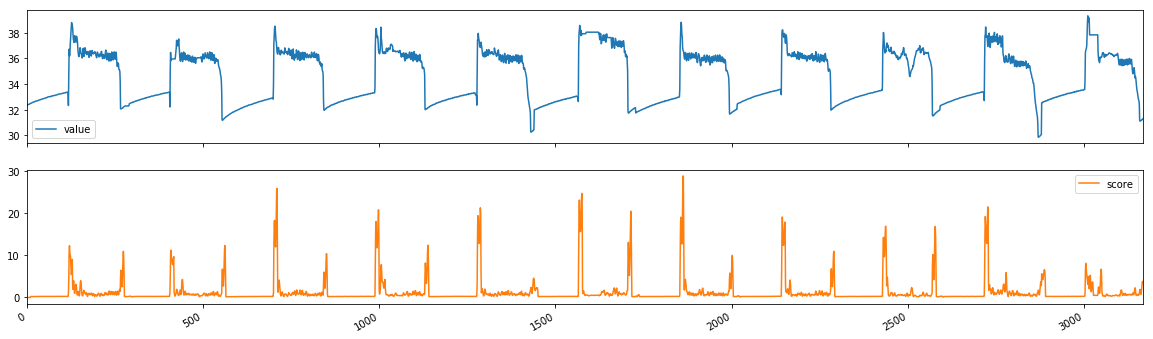

In [292]:
result.plot(figsize=[20,6], subplots=True)